In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd


In [2]:

def load_horses_orig(path, image_size):
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images= []
    test_masks =[]
    for i in range(328):
        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)

        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0


        images.append(low_im)
        masks.append(bin_mask)


    xtest = np.reshape(np.array(images[250:]), (-1,image_size*image_size*3))
    ytest = np.reshape(np.array(masks[250:]), (-1, image_size * image_size))
    xdata = np.reshape(np.array(images[:200]), (-1,image_size*image_size*3))
    ydata = np.reshape(np.array(masks[:200]), (-1, image_size * image_size))
    yval =  np.reshape(np.array(masks[200:250]), (-1, image_size * image_size))
    xval = np.reshape(np.array(images[200:250]), (-1,image_size*image_size*3))


    return xdata, xval, xtest, ydata, yval, ytest


In [6]:
#change the path address
path = 'horses/horses/'
image_size = 32;
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

In [7]:
xdata

array([[ 99,  78,  50, ..., 111, 105,  81],
       [241, 241, 241, ..., 209, 209, 209],
       [122, 148, 113, ..., 179, 188, 110],
       ...,
       [167, 157, 117, ..., 169, 148, 108],
       [223, 223, 223, ..., 163, 112,  68],
       [236, 157,  34, ..., 126,  93,  63]], dtype=uint8)

In [8]:
def draw(image, mask):
  fig, (ax1,ax2) = plt.subplots(1,2)
  ax1.axis('off')
  ax2.axis('off')
  ax1.imshow(np.reshape(image, (image_size,image_size,3)))
  ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
  plt.show()

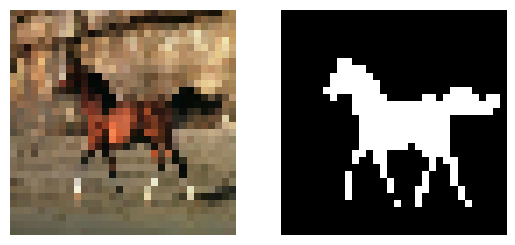

In [9]:
draw(xdata[0], ydata[0])

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming xdata and ydata are numpy arrays
xdata_tensor = torch.tensor(xdata, dtype=torch.float32)
ydata_tensor = torch.tensor(ydata, dtype=torch.float32)

# Create a TensorDataset
train_dataset = TensorDataset(xdata_tensor, ydata_tensor)

# Define batch size and shuffle the data
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


The intersection over union (IOU) is a metric for measuring the performance of image segmentation. The perfect segmentation receives IOU of one.

In [11]:
# Do not change this cell
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt),1)
    union = np.sum(np.maximum(yp, yt),1)
    return np.average(intersect / (union+0.0))


In [12]:
assert iou(ydata, ydata) == 1.0

We can use feedforwad CNN model for image segmentation. Here the input is the image and the output is the segmentation mask.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    """Convolutional NNs baseline in PyTorch."""

    def __init__(self, image_size, num_classes=1, depth=4, base_channels=32, batch=4):
        super(CNN, self).__init__()
        
        self.depth = depth

        # Encoder: each step halves the resolution
        self.encoder_blocks = nn.ModuleList([self.conv_block(1, base_channels)])
        for i in range(1, depth):
            self.encoder_blocks.append(self.conv_block(base_channels * 2**(i-1), base_channels * 2**i))

        # Bottleneck
        self.bottleneck = self.conv_block(base_channels * 2**(depth-1), base_channels * 2**depth)

        # Decoder: each step doubles the resolution
        self.decoder_blocks = nn.ModuleList()
        for i in range(depth, 0, -1):
            self.decoder_blocks.append(self.upconv_block(base_channels * 2**i, base_channels * 2**(i-1)))

        # Final convolution layer
        self.final_conv = nn.Conv2d(base_channels, num_classes, kernel_size=1)
        
        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=1e-5) 

        self.xbatch = batch
        self.ybatch = batch

    # Convolution block (two conv layers + ReLU)
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    # Upsample + Conv block
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )


    #If the predict is true we are returning the sigmoid of the logits as the prediction value for each label
    #If the predict is false we are returning the logits directly.
    def forward(self, x, predict=False):
        # Encoder path
        for i in range(self.depth):
            x = self.encoder_blocks[i](x)
            x = F.max_pool2d(x, 2)
            print(x.shape)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path (no skip connections)
        for i in range(self.depth):
            x = F.interpolate(x, scale_factor=2)
            x = self.decoder_blocks[i](x)
            print(x.shape)

        # Final layer
        logits = self.final_conv(x)
        if predict:
            return torch.sigmoid(logits)
        return logits

    #Complete Me with the loss function
    def get_loss(self, x, yt):
        # the task is segmentation 
        # the loss function should be cross-entropy loss
        logits = self.forward(x)
        print(x.shape)
        print(logits.shape)
        print(yt.shape)
        loss = nn.BCEWithLogitsLoss()(logits, yt)
        return loss
    
    #Complete Me with the training step
    def train_step(self):
        """Perform a single training step."""
        self.train()
        self.optimizer.zero_grad()
        loss = self.get_loss(self.xbatch, self.ybatch)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            y = self.forward(x, predict=True)
        return y.cpu().numpy()



In [39]:
model = CNN(image_size)
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [40]:
#Adopt similar training loop for other problems

max_epoch = 5000
xdata = torch.tensor(xdata, dtype=torch.float32)
xval = torch.tensor(xval, dtype=torch.float32)
xtest = torch.tensor(xtest, dtype=torch.float32)

while epoch < max_epoch:
  loss = 0.0
  for batch in train_loader:
    xbatch, ybatch = batch  # Unpack the batch into inputs and targets

    # Ensure the data is of type float32
    xbatch = xbatch.float()
    ybatch = ybatch.float()

    # Reshape xbatch if needed (assuming xbatch is in shape (batch_size, 3, image_size, image_size))
    xbatch = xbatch.view(-1, image_size, image_size, 3).permute(0,3,1,2)

    # Run the training step and accumulate loss
    loss += model.train_step(xbatch, ybatch)
  # print(xdata.shape)

  ydata_pred = model.predict(xdata.view(-1, image_size, image_size, 3).permute(0,3,1,2) );
  yval_pred = model.predict(xval.view(-1, image_size, image_size, 3).permute(0,3,1,2) );
  ytest_pred = model.predict(xtest.view(-1, image_size, image_size, 3).permute(0,3,1,2) );

  train_iou.append(iou(ydata,ydata_pred))
  # print(xval.shape)
  val_iou.append(iou(yval,yval_pred))
  test_iou.append(iou(ytest,ytest_pred))

  if val_iou[-1] > best_val_iou:
    best_test_iou = test_iou[-1]
    best_val_iou = val_iou[-1]
  display.clear_output(wait=False)

  print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Test: {:0.3}".format( epoch, loss, train_iou[-1], best_test_iou))

  fig, ax = plt.subplots(1,1)
  pd.Series(train_iou).plot(ax=ax)
  pd.Series(val_iou).plot(ax=ax)
  pd.Series(test_iou).plot(ax=ax)
  fig.canvas.draw()

  draw(xdata[0], ydata_pred[0])

  epoch += 1
  # print(ybatch.shape)


C:\Users\24084\AppData\Local\Temp\ipykernel_39812\3521907493.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xdata = torch.tensor(xdata, dtype=torch.float32)
C:\Users\24084\AppData\Local\Temp\ipykernel_39812\3521907493.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xval = torch.tensor(xval, dtype=torch.float32)
C:\Users\24084\AppData\Local\Temp\ipykernel_39812\3521907493.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtest = torch.tensor(xtest, dtype=torch.float32)


TypeError: CNN.train_step() takes 1 positional argument but 3 were given

In [ ]:
ypred_test = model.predict(xtest.view(-1, image_size, image_size, 3).permute(0,3,1,2));

In [ ]:
#Draw couple of examples:
draw(xtest[4]/255.0, ypred_test[4])

In [ ]:
draw(xtest[10]/255.0, ypred_test[10])

In [ ]:
draw(xtest[20]/255.0, ypred_test[20])

### Gradient Descent-Based Inference for Minimizing the Energy of CRF

Conditional Random Fields (CRFs) are graphical models used for structured prediction, where the objective is to model the relationships between input features and output labels, as well as dependencies among the output labels themselves. The goal of inference in CRFs is to find the optimal label configuration that minimizes the total energy of the CRF.

The total energy $ E(\mathbf{y}) $ of a CRF can be defined as the sum of univariate and pairwise potentials:


$$E(\mathbf{y}) = \sum_{i} \phi(y_i) + \sum_{(i, j) \in \mathcal{E}} \psi(y_i, y_j, d_{ij})
$$

where:
- $\phi(y_i)$ is the univariate potential associated with label $y_i$.
- $\psi(y_i, y_j, d_{ij})$ is the pairwise potential between labels $y_i$ and $y_j$, which can be weighted by the distance $d_{ij}$ between the corresponding pixels or nodes.
- $\mathcal{E}$ denotes the set of edges in the graph that represent pairwise relationships.

### Gradient Descent-Based Inference

The objective of gradient descent-based inference is to minimize the energy $ E(\mathbf{y}) $ with respect to the labels $\mathbf{y}$. Since exact inference in CRFs is often intractable due to the complexity of the graphical structure, gradient descent provides an iterative, approximate approach to finding the optimal labels.

#### Steps of Gradient Descent-Based Inference

1. **Initialization**: Start with an initial label configuration, often using random values or a prior estimate. Ensure the labels are continuous (e.g., soft labels) to support gradient-based optimization.

2. **Forward Pass**: Compute the univariate potentials $\phi(y_i)$ using the CNN features and calculate the pairwise potentials $\psi(y_i, y_j, d_{ij})$ using the Gaussian kernel weighted by pixel distances.

3. **Compute Energy**: Calculate the total energy $E(\mathbf{y})$ by summing the univariate and pairwise components.

4. **Backpropagation**: Perform backpropagation to compute the gradients of the energy with respect to the labels:

   $$
   \frac{\partial E(\mathbf{y})}{\partial \mathbf{y}}
   $$

5. **Gradient Update**: Update the labels using the gradients computed:

   $$
   \mathbf{y} \leftarrow \mathbf{y} - \eta \frac{\partial E(\mathbf{y})}{\partial \mathbf{y}}
   $$

   where $\eta$ is the learning rate.

6. **Gradient Clipping**: Optionally, clip the gradients to prevent exploding gradients, which can destabilize the optimization:

   $$
   \text{clip_gradients}(\mathbf{y})
   $$

7. **Iterate**: Repeat the forward pass, energy computation, and gradient update steps for a predefined number of iterations or until convergence.

### Final Label Assignment

After iterating, the resulting label configuration $\mathbf{y}$ should be close to the optimal solution that minimizes the CRF energy, taking into account both the unary potentials (data-driven) and the pairwise potentials (enforcing spatial coherence).




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class CRF(nn.Module):
    def __init__(self, num_labels):
        super(CRF, self).__init__()
        self.num_labels = num_labels
        self.sigma = 1.0
        # Univariate potential: Linear layer for each label using CNN features
        self.unary_weights = torch.ones(num_labels)


    def forward(self, x):
        # Compute unary potentials using CNN features
        pass


    #Calculate the energy of the CRF
    def energy(self, labels, unary_potentials):
        pass

    #Gradient descent-based inference using CRF
    def gradient_descent_inference(self, x, yt, max_iters=1000, lr=0.01):

        inf_energy = []
        inf_iou = []
        # Initialize label assignments randomly

        labels = torch.rand_like(cnn_features, requires_grad=True)

        # Optimizer for label updates
        optimizer = optim.SGD([labels], lr=lr)


        for iter in range(max_iters):
            #Complete Me with inference steps
            energy =  ...

            inf_energy.append(energy.detach().numpy().item())
            inf_iou.append(iou(yt, labels.detach().numpy()))
            if iter % 10 == 0:
                display.clear_output(wait=False)
                fig, (ax1, ax2) = plt.subplots(1,2)
                pd.Series(inf_iou).plot(ax=ax1)
                pd.Series(inf_energy).plot(ax=ax2)
                fig.canvas.draw()
                draw(x, labels.detach().numpy())
        return labels

num_labels = 32*32
image_size = 32

# Initialize CNN and CRF models
crf = CRF(num_labels)





In [ ]:
#Run this cell
crf.gradient_descent_inference(xtest[0:1], ytest[0:1])

In [ ]:
#Run this cell
crf.gradient_descent_inference(xtest[4:5], ytest[4:5])

In [ ]:
#Run this cell
crf.gradient_descent_inference(xtest[10:11], ytest[10:11])